In [1]:
import pandas as pd
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
seed = 42
np.random.seed(seed)

# Introduction  

In this project, my goal is two pronged:  
  1. Extract common topics 
  2. Given a document, predict which political party that text originated from
  
# Data  

## Read raw text  
In this case the raw text is all State of the Union addresses since 1791. 

In [2]:
path = 'state-of-the-union-corpus-1989-2017'
dirs = os.listdir(path)

In this step, I parse the filename to get the year and president and attach that to the text for that speech.

In [3]:
df = pd.DataFrame(columns=['year', 'president', 'party', 'text'])

for i in range(len(dirs)):
    components = dirs[i].split('_')
    name = components[0]
    year = components[1].split('.')[0]
    df.loc[i,'year'] = year
    df.loc[i,'president'] = name   
    
    filename = os.path.join(path, dirs[i])
    text_file = open(filename, "r")
    
    lines = text_file.read()
    lines = lines.replace('\n', ' ')
    df.loc[i, 'text'] = lines.lower()
    
df.year = df.year.astype(int) 
df.president = df.president.astype(str)
df.text = df.text.astype(str)
print('Shape: ', df.shape)

Shape:  (228, 4)


There are a few presidents that have the same last name (Roosevelt, Bush, Johnson and Adams), so let's clean that up now.

In [4]:
# need to distinuish between Theodore Roosevelt and Franklin D. Roosevelt
indices = df.query("president =='Roosevelt' & year <= 1909").index
df.loc[indices,'president'] = 'Theodore Roosevelt'

indices = df.query("president == 'Roosevelt'").index
df.loc[indices,'president'] = 'Franklin D. Roosevelt'

indices = df.query("president =='Bush' & year <= 1992").index
df.loc[indices,'president'] = 'George H. W. Bush'

indices = df.query("president == 'Bush'").index
df.loc[indices,'president'] = 'George W. Bush'

indices = df.query("president =='Johnson' & year <= 1869").index
df.loc[indices,'president'] = 'Andrew Johnson'

indices = df.query("president == 'Johnson'").index
df.loc[indices,'president'] = 'Lyndon B. Johnson'

indices = df.query("president =='Adams' & year <= 1801").index
df.loc[indices,'president'] = 'John Adams'

indices = df.query("president == 'Adams'").index
df.loc[indices,'president'] = 'John Quincy Adams'


indices = df.query("president =='Harrison' & year <= 1841").index
df.loc[indices,'president'] = 'William Henry Harrison'

indices = df.query("president == 'Harrison'").index
df.loc[indices,'president'] = 'Benjamin Harrison'

Now let's attach the political party to the president (note some presidents changed parties throughout their political career, I am simply listing the party they belonged to while serving as President).

In [5]:
def pres_to_party(name):
    republican = ['Lincoln', 'Grant', 'Hayes', 'Garfield', 'Arthur', 
                  'Benjamin Harrison', 'McKinley', 'Theodore Roosevelt', 
                  'Taft', 'Harding', 'Coolidge', 'Hoover', 'Eisenhower', 
                  'Nixon', 'Ford', 'Reagan', 'George H. W. Bush', 
                  'George W. Bush', 'Trump']
    if name in republican:
        return 'Republican'
    
    democratic = ['Jackson', 'Buren', 'Polk', 'Pierce', 
                  'Buchanan', 'Cleveland', 'Wilson', 'Franklin D. Roosevelt', 
                  'Truman', 'Kennedy', 'Lyndon B. Johnson', 'Carter', 'Clinton', 'Obama']
    if name in democratic:
        return 'Democratic'
    
    whig = ['William Henry Harrison', 'Taylor', 'Fillmore']
    if name in whig:
        return 'Whig'
    
    national_union = ['Andrew Johnson']
    if name in national_union:
        return 'National Union'
    
    
    unaffiliated = ['Washington', 'Tyler']
    if name in unaffiliated:
        return 'Unaffiliated'
    
    federalist = ['John Adams']
    if name in federalist:
        return 'Federalist'
    
    democratic_republican = ['Jefferson', 'Madison', 'Monroe', 'John Quincy Adams']
    if name in democratic_republican:
        return 'Democratic-Republican'

In [6]:
df.party = df.president.apply(pres_to_party)

df.set_index('year', inplace=True)
df.sort_index(inplace=True)
df.head()

,president,party,text
year,,,
1790,Washington,Unaffiliated,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [7]:
df.groupby('party').size()

party
Democratic               88
Democratic-Republican    28
Federalist                4
National Union            4
Republican               89
Unaffiliated             11
Whig                      4
dtype: int64

We are simply going to drop those SOTU addresses delivered by presidents that were not a member of the Democratic or Republican party.  

Since nearly all SOTU addresses start with an acknowledement, we can remove this boilerplate text as it will not add anything to our topic model.

In [8]:
df_new = df[df.party.isin(['Democratic','Republican'])]

In [9]:
import re

def remove_acknowledgement(text):
    return text[re.match('[^\:]*', text).end()+2:]

df_new.text = df_new.text.apply(remove_acknowledgement)

In [10]:
df_new.head()

,president,party,text
year,,,
1829,Jackson,Democratic,it affords me pleasure to tender my friendly ...
1830,Jackson,Democratic,the pleasure i have in congratulating you upo...
1831,Jackson,Democratic,the representation of the people has been ren...
1832,Jackson,Democratic,it gives me pleasure to congratulate you upon...
1833,Jackson,Democratic,on your assembling to perform the high trusts...


## Clean text  

Here I clean up each speech: explicitly I remove all punctuation and stop words, POS tag each word and use this information as well as the word to convert it to it's lemma.

In [11]:
from gensim import models, corpora
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
STOPWORDS = stopwords.words('english')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return lemmatize_sent(' '.join(cleaned_text))

In [13]:
df_new['tokens'] = df_new.text.apply(clean_text)
df_new.head()

,president,party,text,tokens
year,,,,
1829,Jackson,Democratic,it affords me pleasure to tender my friendly ...,"[affords, pleasure, tender, friendly, greeting..."
1830,Jackson,Democratic,the pleasure i have in congratulating you upo...,"[pleasure, congratulate, upon, return, constit..."
1831,Jackson,Democratic,the representation of the people has been ren...,"[representation, people, renew, time, since, c..."
1832,Jackson,Democratic,it gives me pleasure to congratulate you upon...,"[give, pleasure, congratulate, upon, return, s..."
1833,Jackson,Democratic,on your assembling to perform the high trusts...,"[assemble, perform, high, trust, people, unite..."


Let's make a **word cloud**, using the original text (not tokenized).

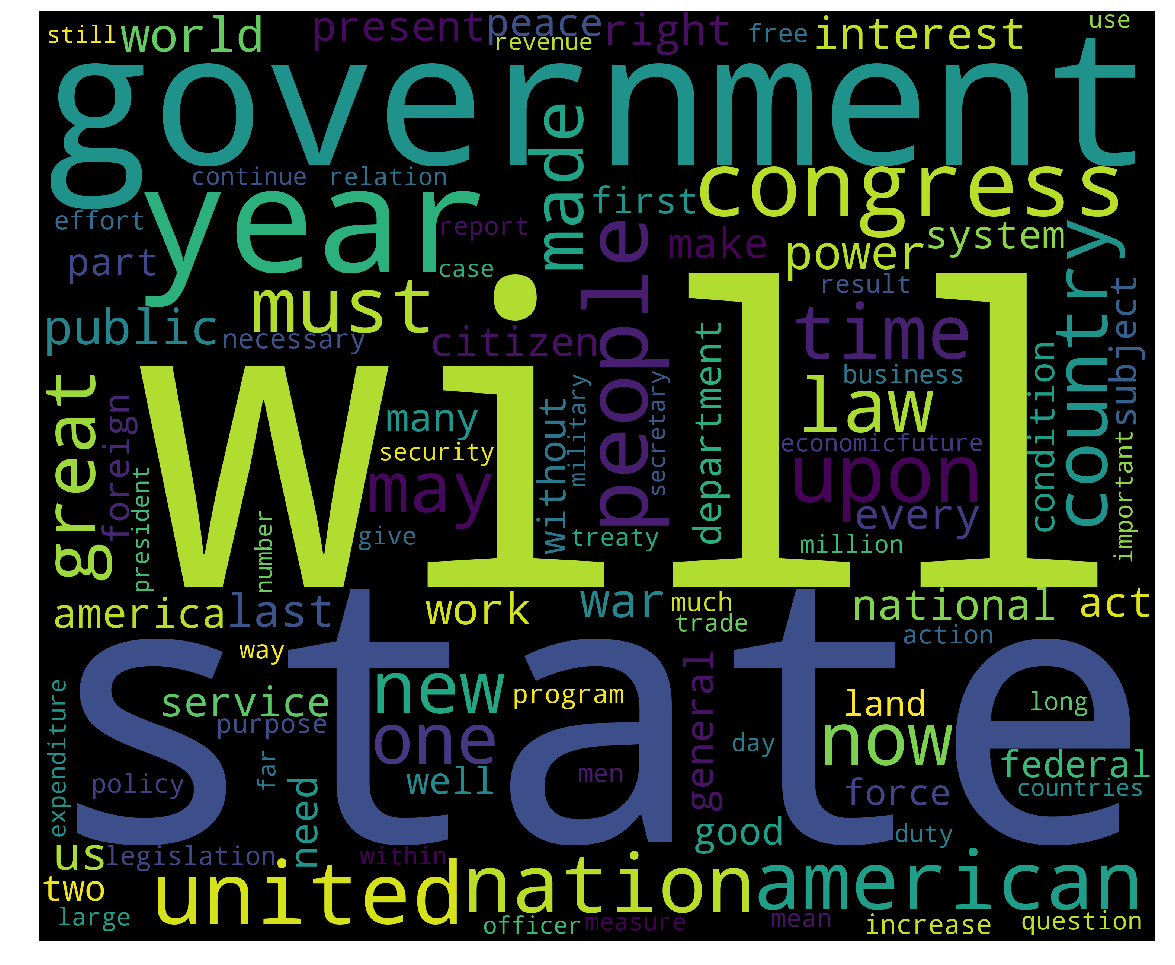

In [74]:
#WordCloud
from wordcloud import WordCloud, STOPWORDS

cleaned_text = ' '.join(list(df_new.text))

wordcloud = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(cleaned_text)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Let's make a **word cloud** using our **tokens** (POS taggged and lemmatized).

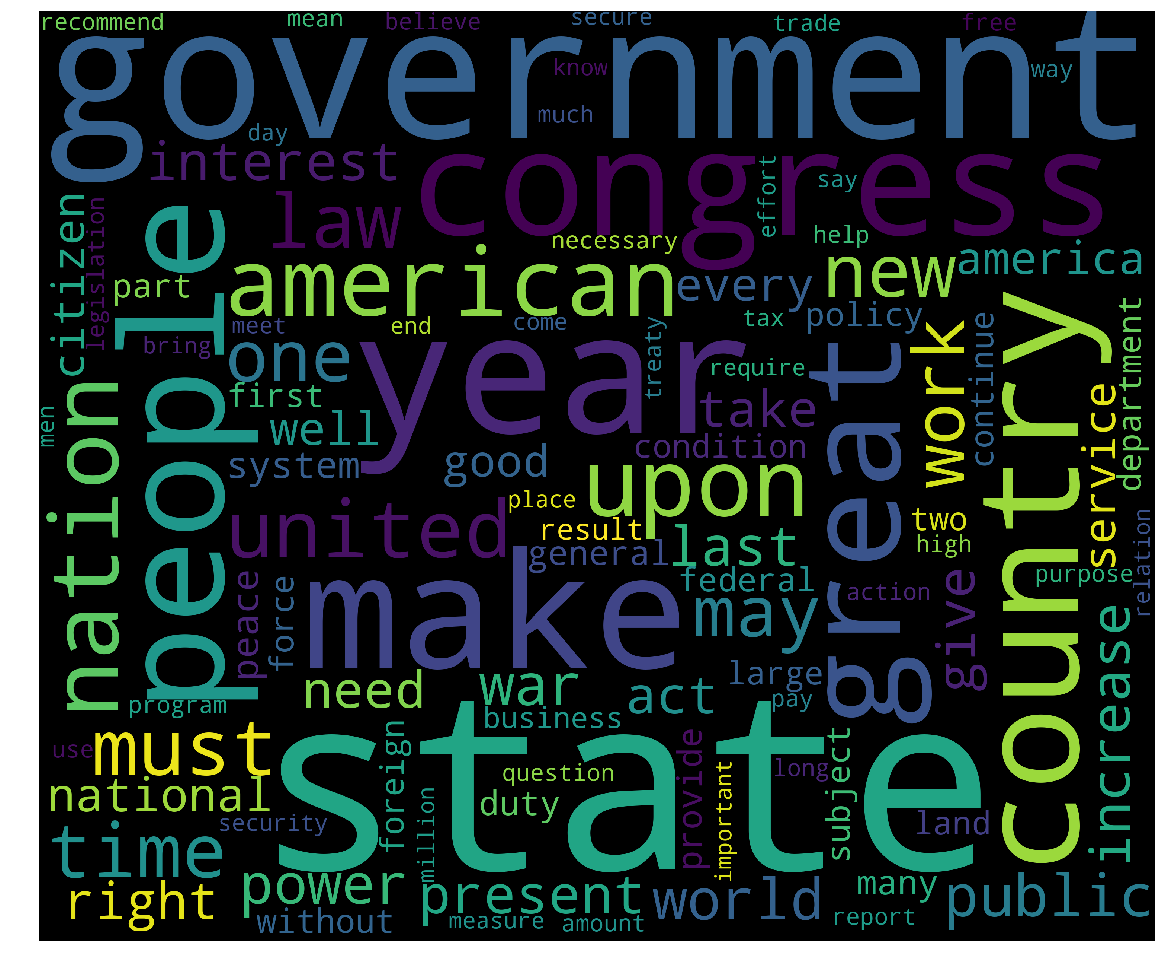

In [75]:
token_string = ''
for tokens in df_new.tokens:
    token_string += ' '.join(tokens) + ' '

wordcloud_tokens = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(token_string)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud_tokens)
plt.axis('off')
plt.show()

# Topic Modeling

In [30]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df_new.tokens)

'''
We can "control" the level in which we extract topics from:
  * We can filter out tokens that show up in x% of all SOTU's, in effect
    uncovering more hidden topics (only present in (1-x)% of the SOTUs).
  * A similar strategy can be used to filter out very rare tokens by setting
    no_below
'''

#### FIRST SET OF HYPER-PARAMETERS

dictionary.filter_extremes(no_above=.05)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df_new.tokens]

NUM_TOPICS = 10

# Update the model to find more topics
lda_model = models.LdaModel(corpus=corpus, 
                            random_state=seed,
                            iterations=100,
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

## Topic Visualization

In [31]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis


vis_data_lda = gensimvis.prepare(lda_model, corpus, dictionary)
#pyLDAvis.save_html(vis_data_lda,'lda_all.html')
pyLDAvis.display(vis_data_lda)

These topics all look pretty disjoint, although there is some overlap between topics 1, 3, 4 and 5. To get some more clarification on how individual words are related to each other (in the SOTU corpus), we can perform dimensionality reduction via truncated SVD on our bag of words matrix, and plot these 2 components. 

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

tokenized_docs = []
for tokens in df_new.tokens:
    ts = ' '.join(tokens)
    tokenized_docs.append(ts)
    


cv = CountVectorizer(stop_words='english', 
                     max_df=.05)
bow = cv.fit_transform(tokenized_docs).toarray()
 
# Build a Latent Dirichlet Allocation Model
lda_model2 = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=100, learning_method='online')
lda_Z = lda_model2.fit_transform(bow)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [35]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
output_notebook()

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(bow.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], cv.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Loading BokehJS ...

**Note, you can zoom in/out of this plot.**

Now that we have extracted the top 10 most likely topics, we can apply them to each address separately.

In [41]:
lda_scores = [] #np.array((len(corpus), NUM_TOPICS))

for i in range(len(corpus)):
    y = lda_model[corpus[i]]
    #lda_scores.append([score[1] for score in y])
    lda_scores.append({score[0]:score[1] for score in y})

lda_df = pd.DataFrame(lda_scores)
lda_df.index = df_new.index
lda_df.fillna(0.0, inplace=True) # not sure about this...

lda_df.head()

,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
1829,0.0,0.989023,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1830,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.993381
1831,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.986565,0.000000
1832,0.0,0.000000,0.0,0.0,0.0,0.0,0.983926,0.0,0.000000,0.000000
1833,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.981248,0.000000


Attach political party to lsi_scores to see if there is any major differences between the political parties.

In [42]:
lda_df.columns = ['topic_' + str(i) for i in range(NUM_TOPICS)]
lda_df.loc[:,'other'] = (1 - lda_df.sum(axis=1))
lda_df['party'] = df_new.party
lda_df.groupby('party').mean()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,other
party,,,,,,,,,,,
Democratic,0.020037,0.121186,0.112956,0.074358,0.088429,0.110389,0.081614,0.129605,0.121169,0.125150,0.015107
Republican,0.086675,0.054909,0.072198,0.182894,0.171656,0.079953,0.121663,0.072148,0.066176,0.078072,0.013656


In [43]:
lda_df.groupby('party').var()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,other
party,,,,,,,,,,,
Democratic,0.012410,0.097987,0.088745,0.059580,0.069778,0.093498,0.069928,0.100521,0.093078,0.100344,0.000136
Republican,0.071514,0.041821,0.056047,0.134132,0.121852,0.064627,0.093650,0.057426,0.048058,0.062334,0.000074


Now let us calculate the "running average" for a given topic: the average topic coverage (score) from year 0 (1830) up until year *i*, for all *i* in years.

In [48]:
rolling_avg = lda_df.copy()
window_size = 4 # years

for i in range(rolling_avg.shape[0]):
    for j in range(NUM_TOPICS):
        start = max(0, i-window_size)
        rolling_avg.iloc[i,j] = lda_df.iloc[start:i+1,j].mean()  
rolling_avg.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,other,party
year,,,,,,,,,,,,
1829,0.0,0.989023,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.010977,Democratic
1830,0.0,0.494511,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.496691,0.006619,Democratic
1831,0.0,0.329674,0.0,0.0,0.0,0.0,0.000000,0.0,0.328855,0.331127,0.013435,Democratic
1832,0.0,0.247256,0.0,0.0,0.0,0.0,0.245981,0.0,0.246641,0.248345,0.016074,Democratic
1833,0.0,0.197805,0.0,0.0,0.0,0.0,0.196785,0.0,0.393563,0.198676,0.018752,Democratic


In [49]:
def plot_rolling_topic_coverage(topic_no, window_size = 4):
    
    g = sns.factorplot(x=rolling_avg.index, y='topic_'+str(topic_no), hue='party', kind='bar', data=rolling_avg)
    for ax in g.axes.flatten():
        ax.set_ylabel('Topic Coverage')
        ax.set_xticklabels('')
        ax.set_xticks([])
    plt.gcf().set_size_inches(20, 10)
    # Setting figure size ....(NEED HELP HERE in setting height of figure)

    fig = plt.gcf()
    # Setting the figure heading text ....(NEED HELP HERE with the text locations)
    
    title = "Topic {}, window size of {}".format(topic_no, window_size)
    fig.suptitle(title, fontsize=50, verticalalignment = "top", horizontalalignment = 'center')
    #fig.text(0.01,-0.05, lda_model.print_topic(topic_no, NUM_TOPICS), fontsize = 40)       
    plt.tight_layout()
    plt.show()
    print(lda_model.print_topic(topic_no, NUM_TOPICS))

In [50]:
sigma = lda_df.groupby('party').std()
sigma.iloc[0,:] / sigma.iloc[1,:]

topic_0    0.416569
topic_1    1.530698
topic_2    1.258333
topic_3    0.666475
topic_4    0.756731
topic_5    1.202805
topic_6    0.864120
topic_7    1.323050
topic_8    1.391687
topic_9    1.268769
other      1.355892
dtype: float64

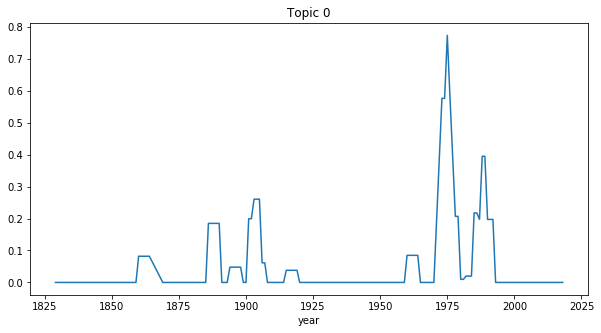

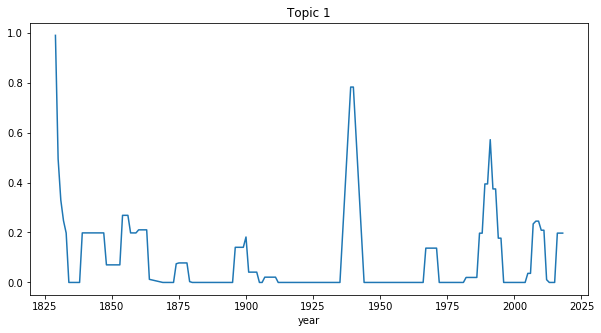

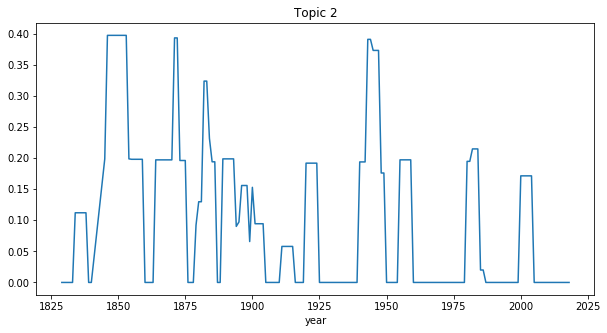

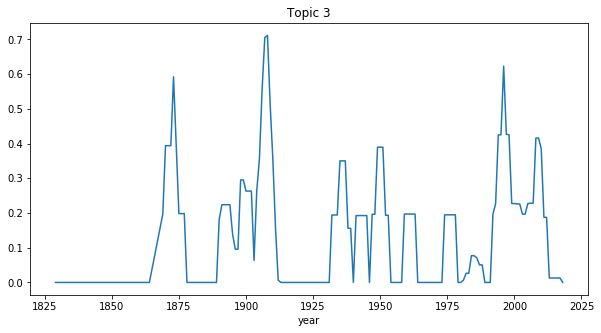

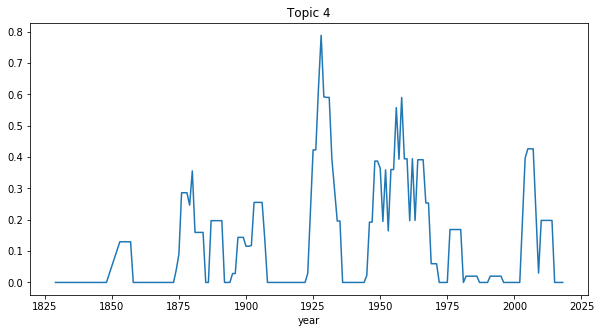

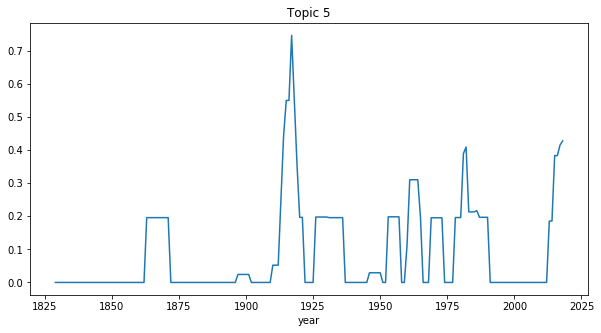

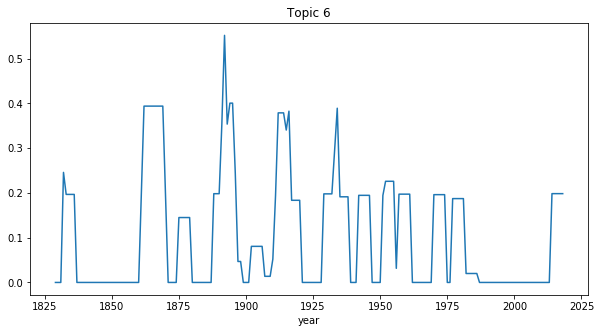

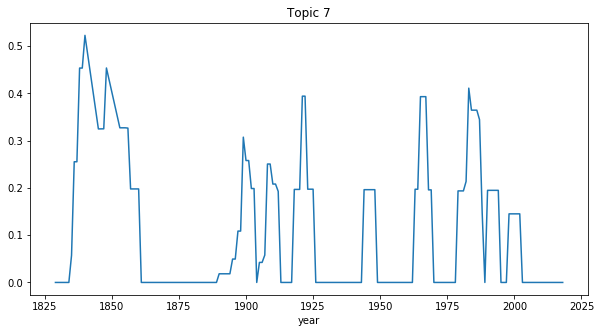

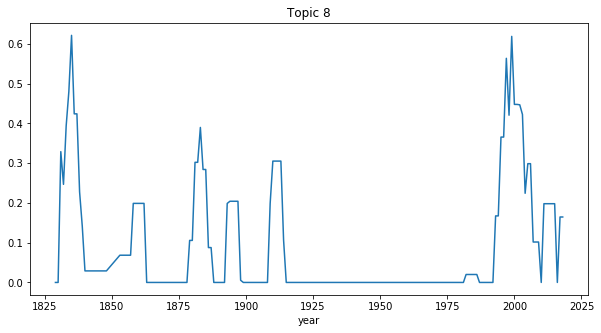

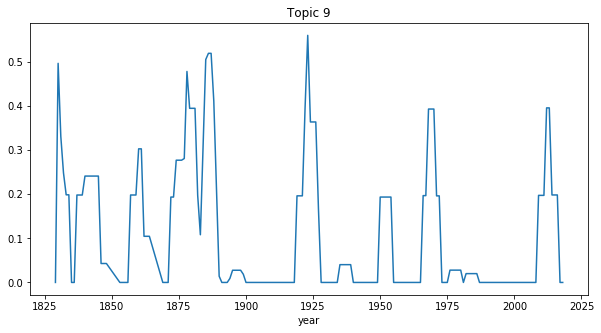

In [51]:
for i in range(NUM_TOPICS):
    plt.figure(figsize=(10,5))
    plt.title("Topic " + str(i))
    rolling_avg.iloc[:,i].plot()
    plt.show()

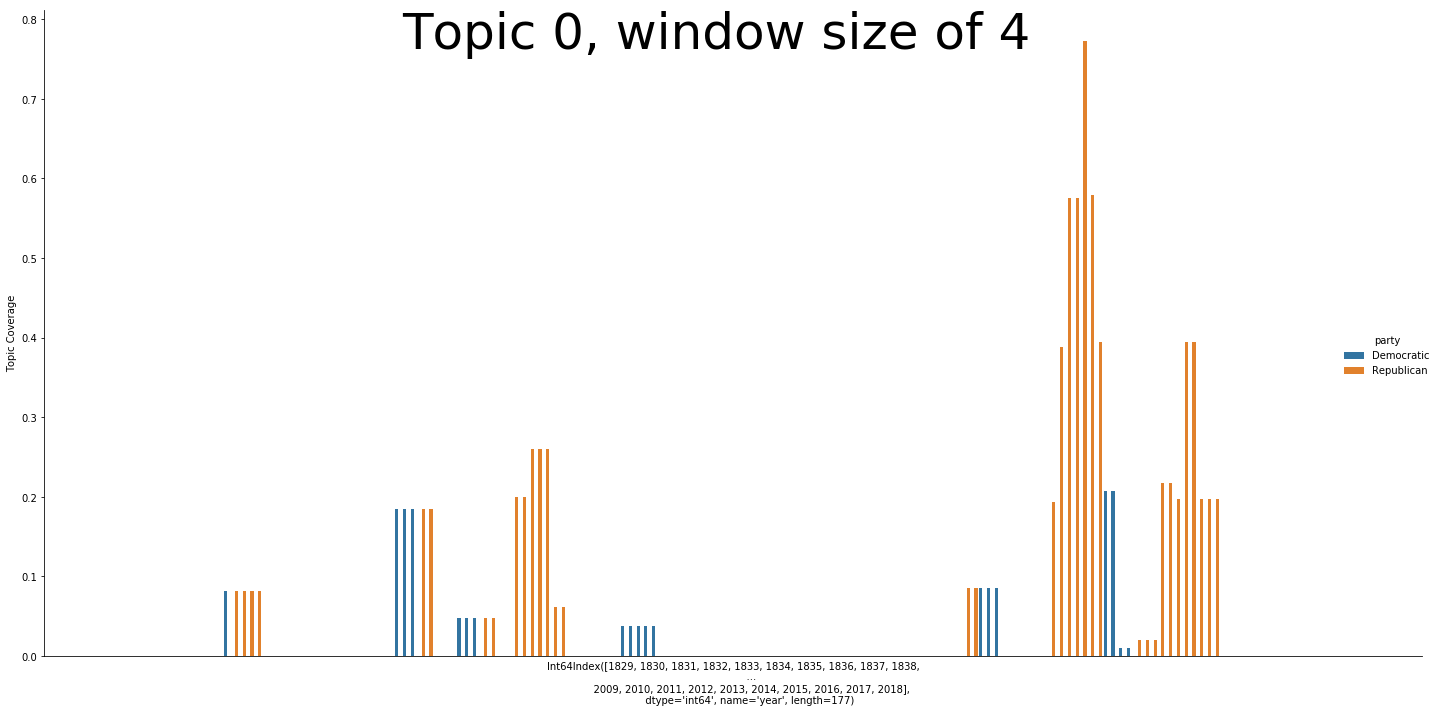

0.008*"barrel" + 0.006*"crude" + 0.005*"wage-worker" + 0.005*"unborn" + 0.005*"mckinley" + 0.005*"upbuilding" + 0.004*"riot" + 0.004*"wage-workers" + 0.004*"abortion" + 0.004*"freshman"


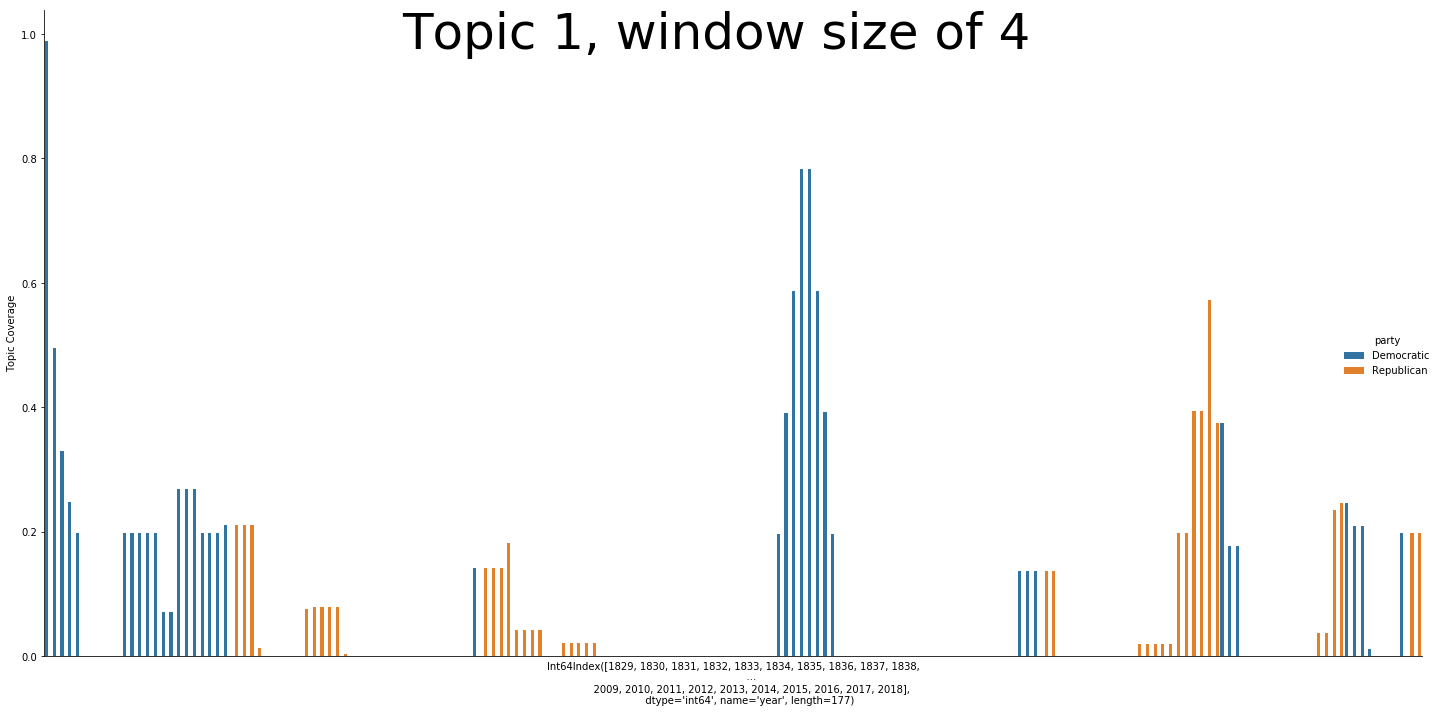

0.005*"extremist" + 0.004*"persian" + 0.003*"baghdad" + 0.003*"earmark" + 0.003*"privateer" + 0.003*"steamboat" + 0.003*"saddam" + 0.003*"arena" + 0.003*"militarism" + 0.003*"madison"


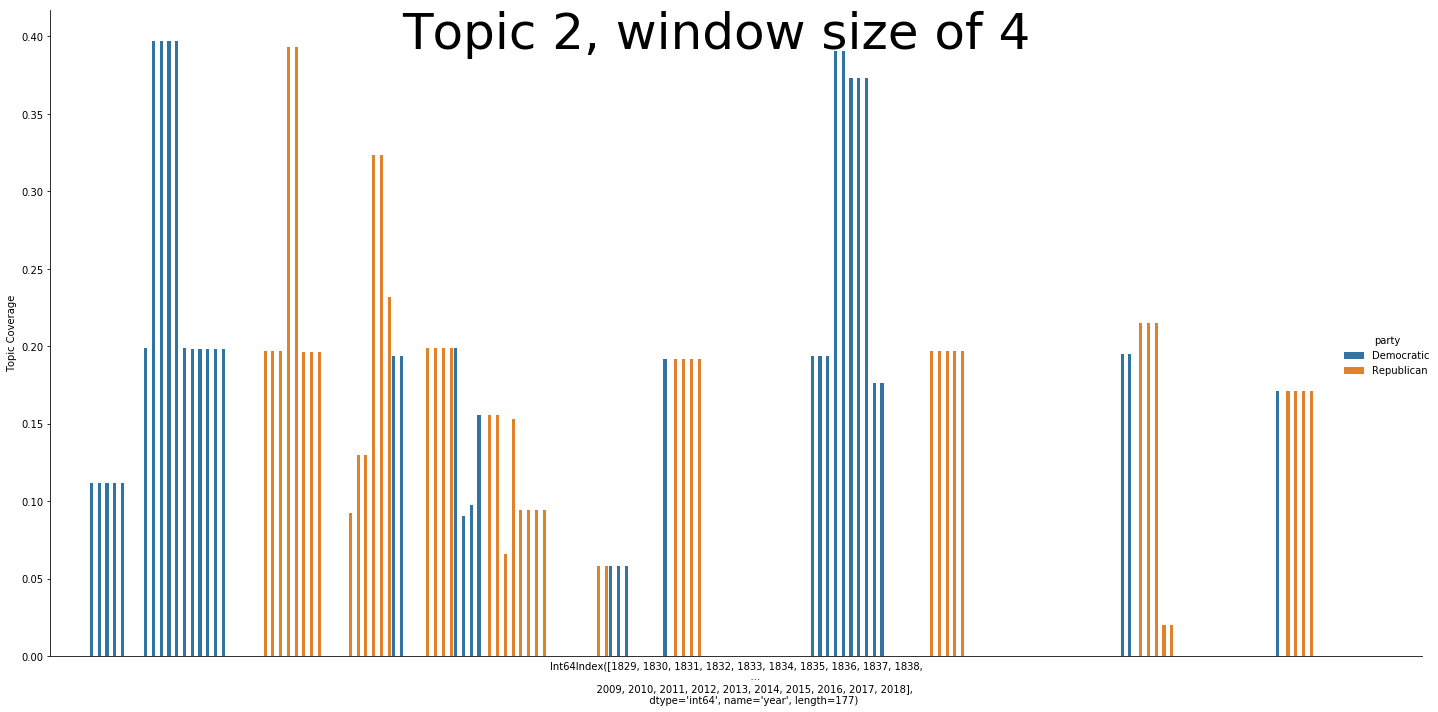

0.008*"wool" + 0.005*"wine" + 0.005*"hon" + 0.005*"texan" + 0.004*"mosquito" + 0.003*"anti-trust" + 0.003*"persian" + 0.003*"tank" + 0.003*"sun" + 0.003*"rating"


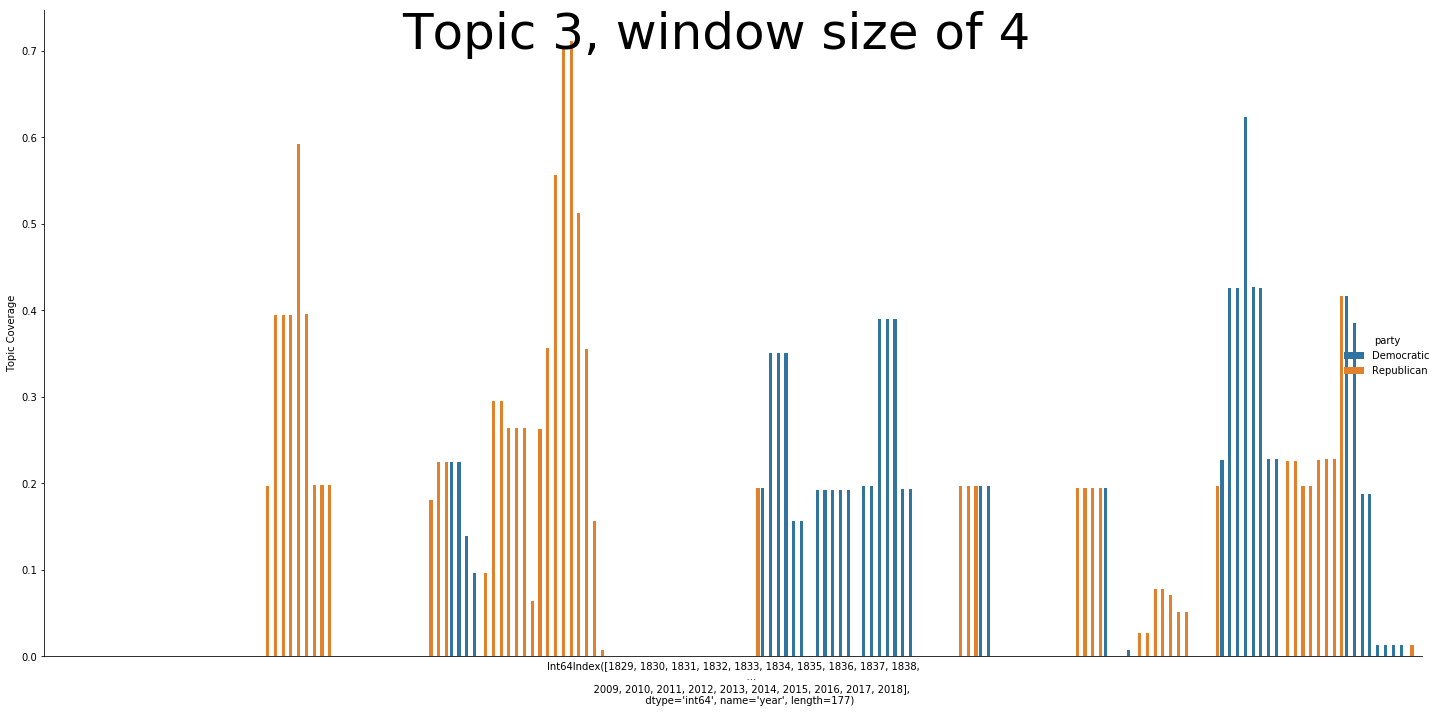

0.006*"santiago" + 0.005*"richard" + 0.004*"rebate" + 0.004*"wrongdoing" + 0.004*"wage-workers" + 0.004*"mayor" + 0.003*"boycott" + 0.003*"ethical" + 0.003*"brady" + 0.003*"lebanon"


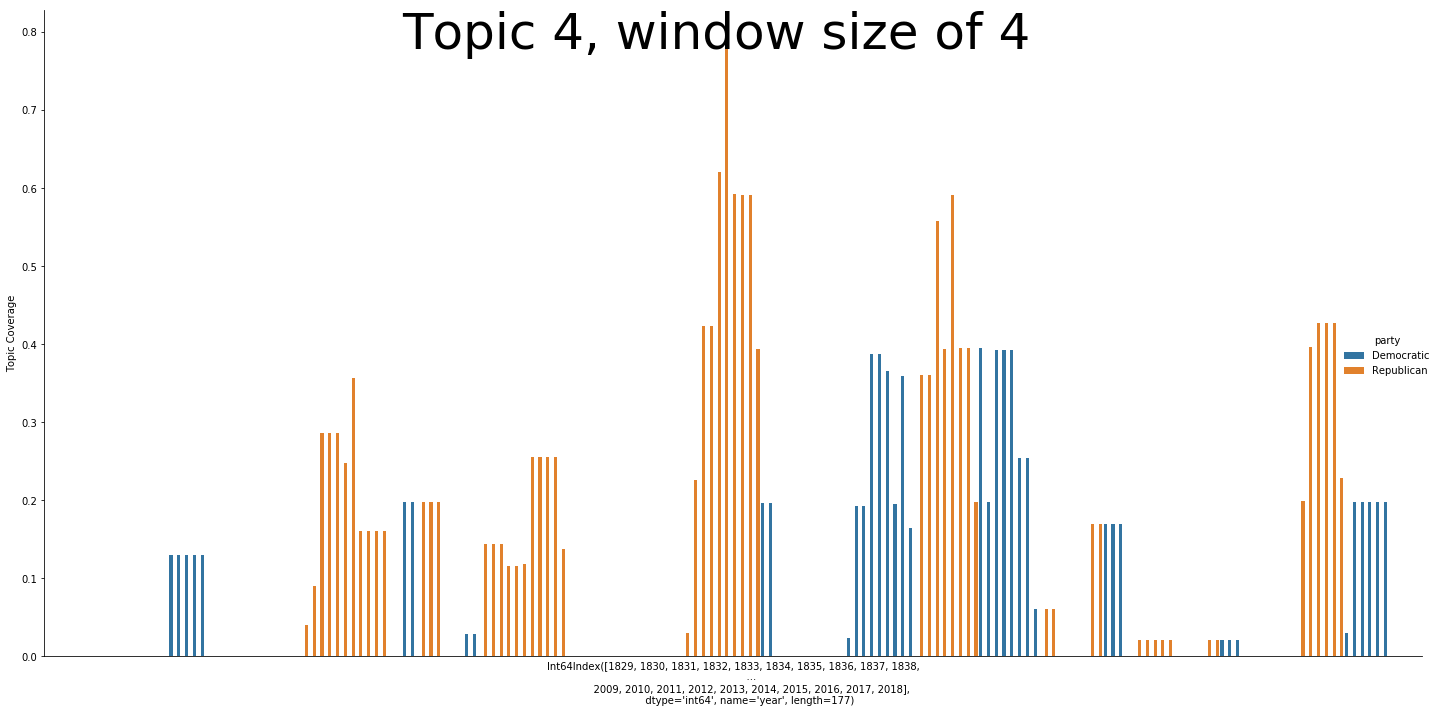

0.011*"saddam" + 0.011*"hussein" + 0.007*"wool" + 0.006*"nitrate" + 0.004*"sheep" + 0.004*"expatriation" + 0.003*"mentor" + 0.003*"lobbyist" + 0.003*"inventory" + 0.003*"tinder"


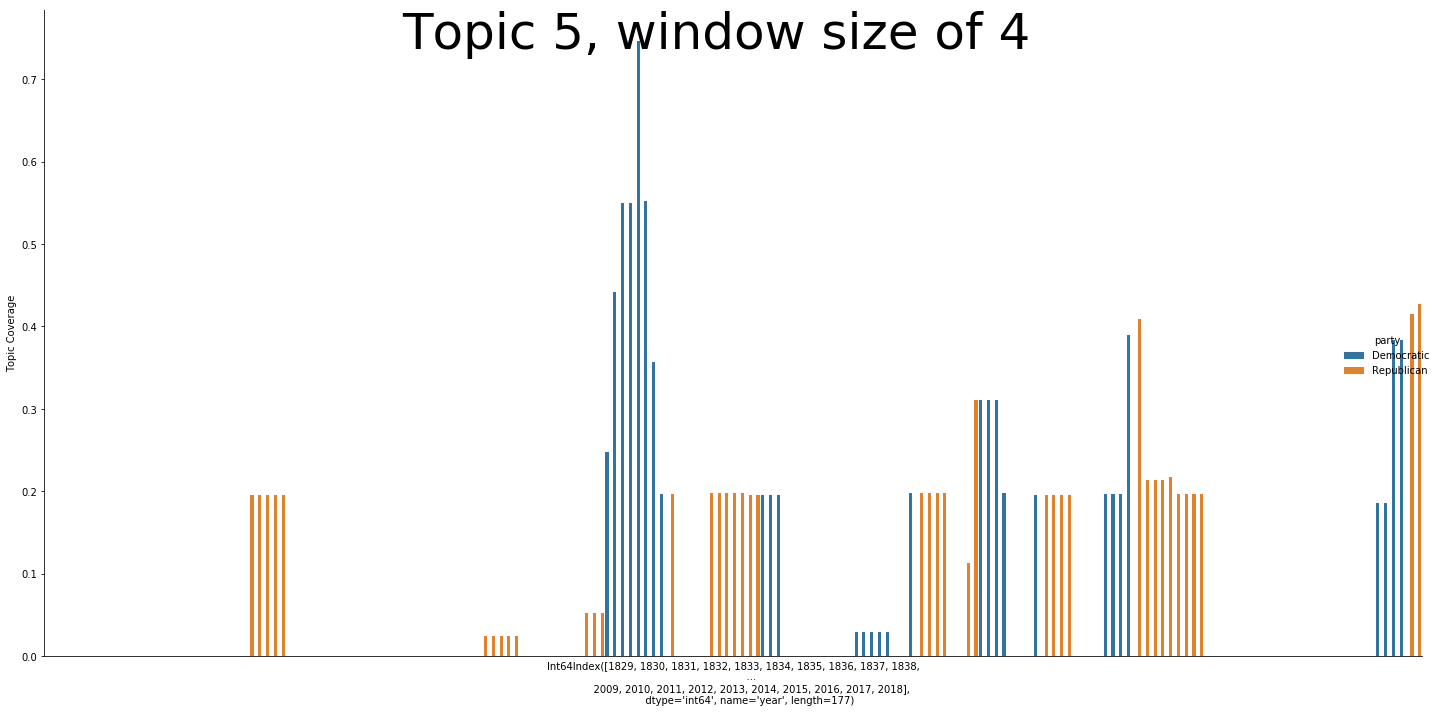

0.004*"pillar" + 0.004*"inventory" + 0.004*"music" + 0.004*"surtax" + 0.004*"paperwork" + 0.003*"operational" + 0.003*"persian" + 0.003*"ryan" + 0.003*"scout" + 0.003*"synthetic"


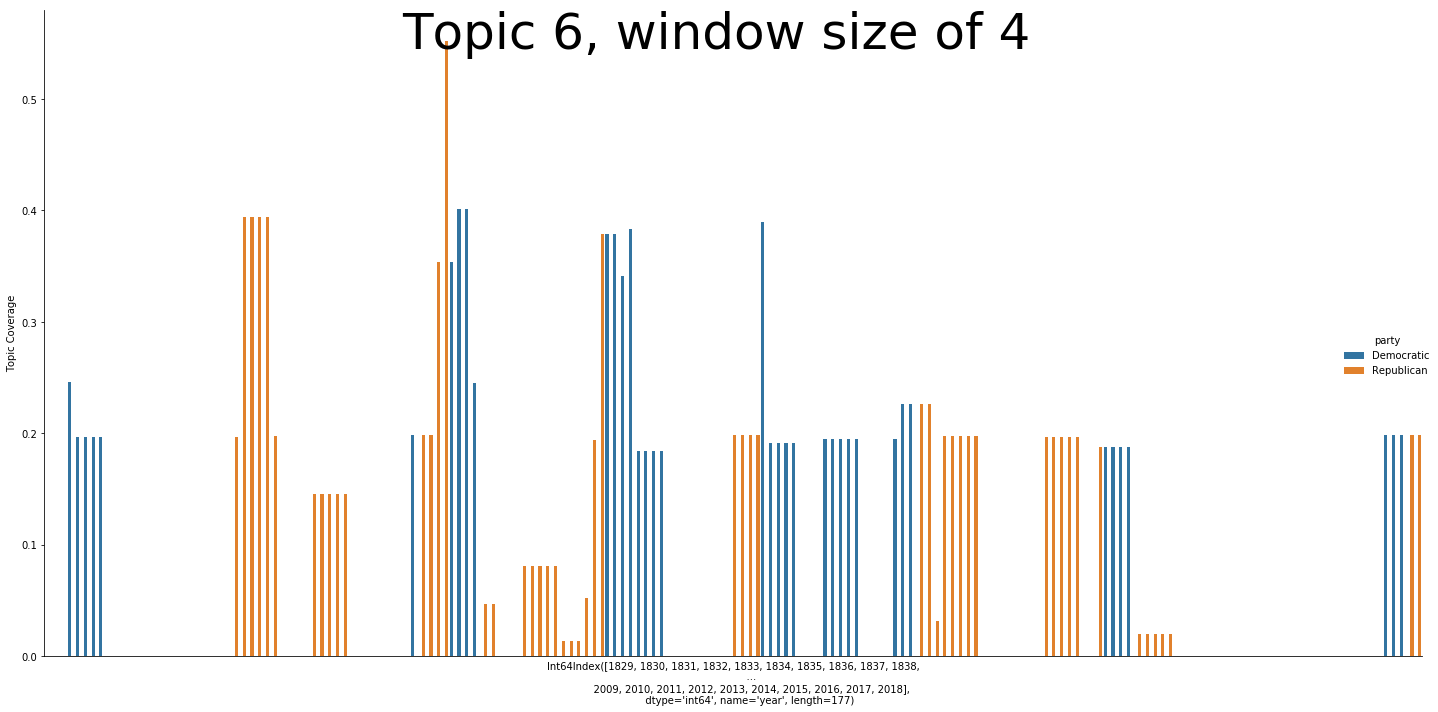

0.011*"wool" + 0.005*"tank" + 0.005*"opium" + 0.004*"anti-trust" + 0.004*"seventy" + 0.003*"workforce" + 0.003*"santa" + 0.003*"advertisement" + 0.003*"exploitation" + 0.003*"tinder"


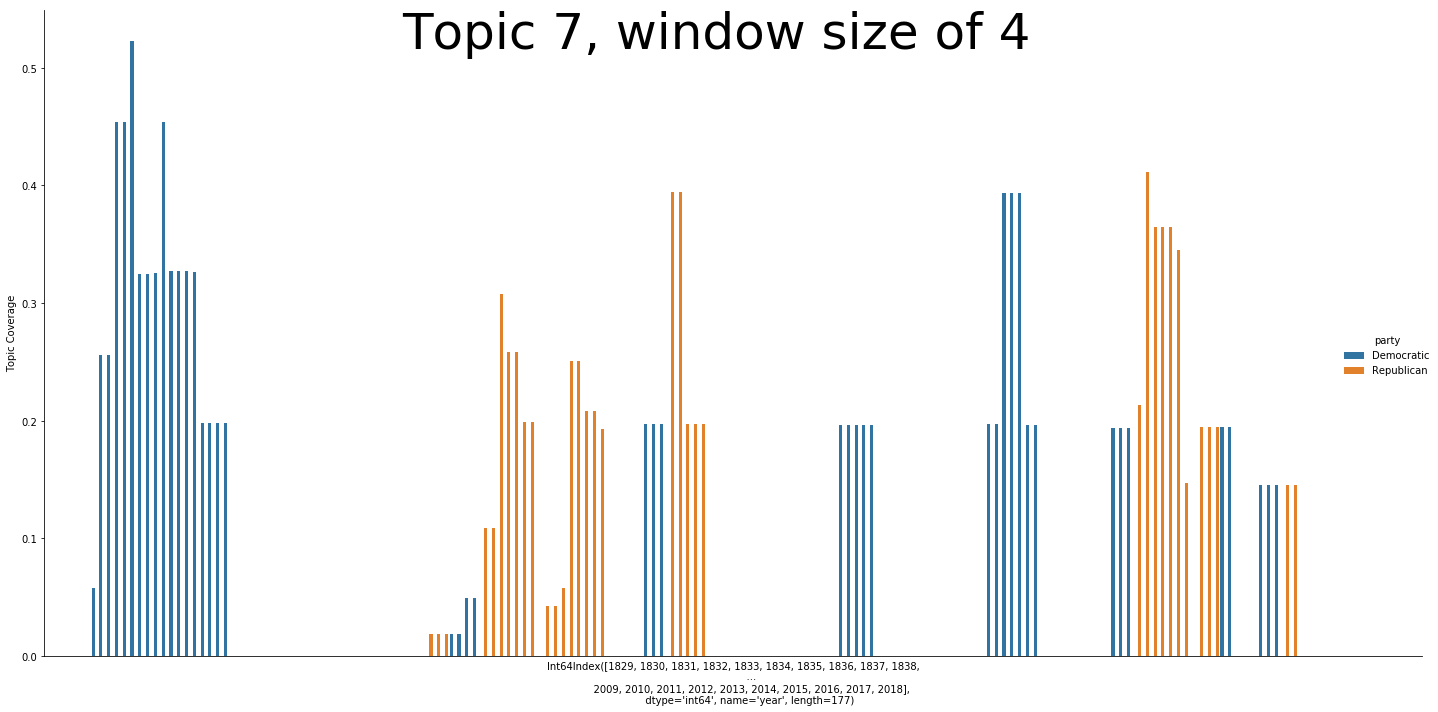

0.006*"salt" + 0.003*"thoroughgoing" + 0.003*"ministry" + 0.003*"seminole" + 0.003*"holland" + 0.003*"hon" + 0.002*"bosnia" + 0.002*"realism" + 0.002*"wrongdoing" + 0.002*"odious"


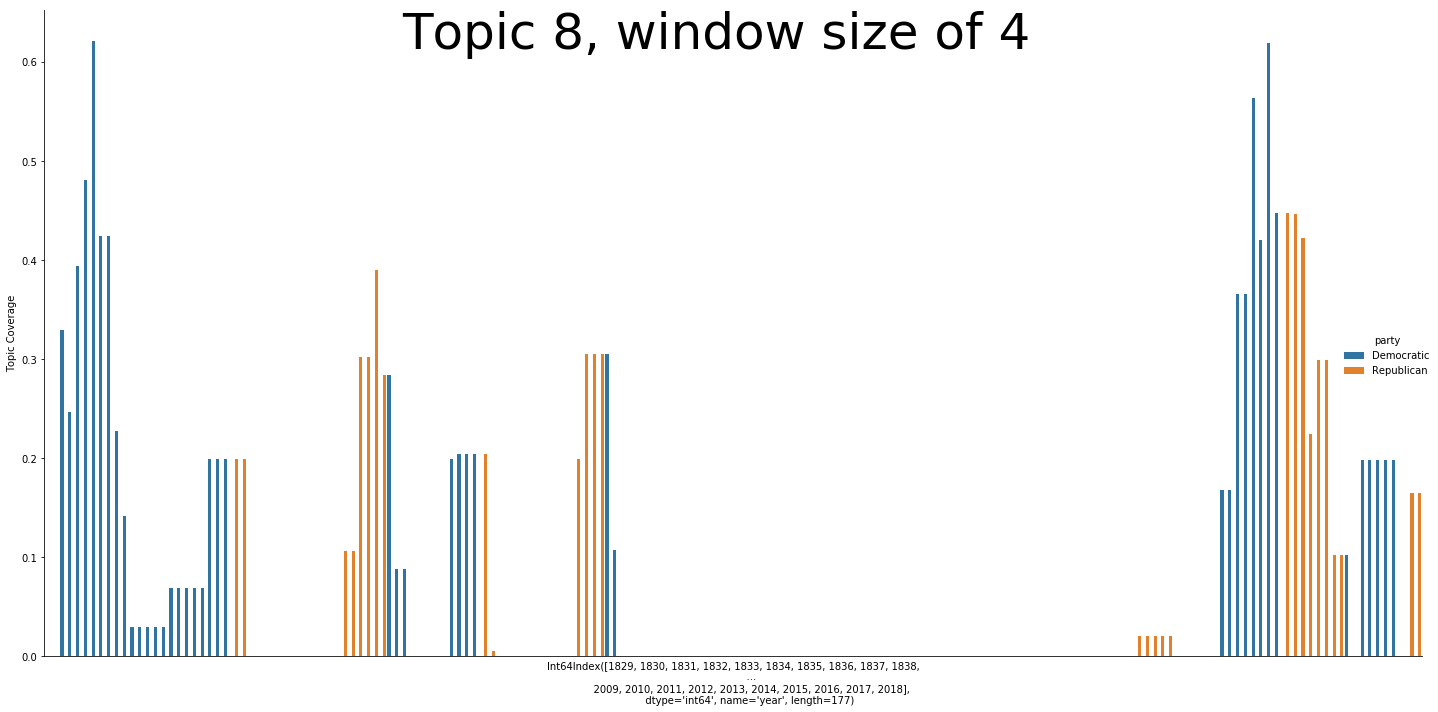

0.006*"ministry" + 0.005*"americorps" + 0.004*"lobbyist" + 0.004*"reinvent" + 0.003*"saddam" + 0.003*"millennium" + 0.003*"periodical" + 0.003*"robert" + 0.003*"usa" + 0.003*"second-class"


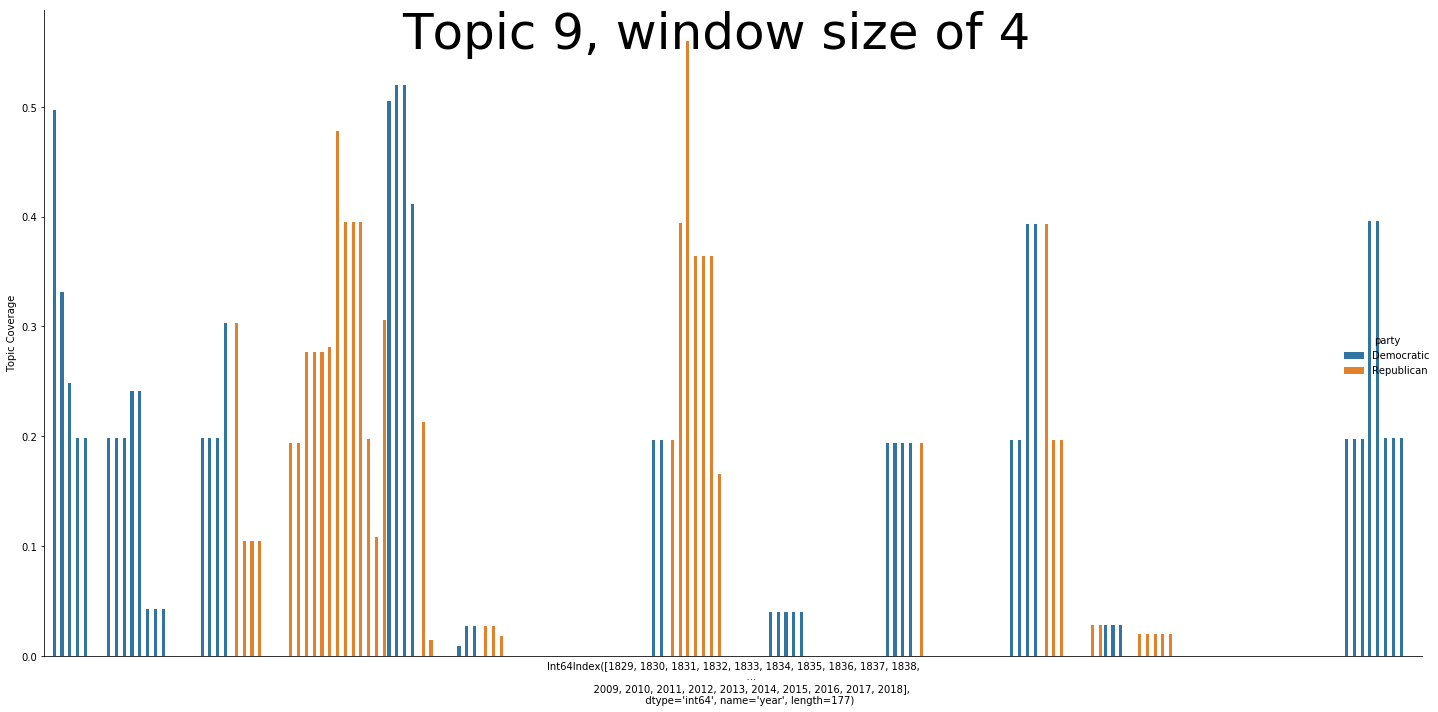

0.004*"motor" + 0.004*"subscription" + 0.004*"legal-tender" + 0.004*"lending" + 0.004*"trustee" + 0.004*"kongo" + 0.003*"insistent" + 0.003*"canton" + 0.003*"pestilence" + 0.003*"intrusion"


In [52]:
for i in range(NUM_TOPICS):
    plot_rolling_topic_coverage(i)

In [53]:
lda_df.iloc[:,:10].sum().sort_values(ascending=False) / lda_df.shape[0]

topic_4    0.130278
topic_3    0.128933
topic_6    0.101751
topic_9    0.101478
topic_7    0.100714
topic_5    0.095085
topic_8    0.093517
topic_2    0.092462
topic_1    0.087860
topic_0    0.053544
dtype: float64

**Takeaway**:  
When the ball gets rolling, it maintains its' momentum (regardless of the political party in office). Once a topic is introduced, it gains coverage gradually, and is gradually phased out. Topic 8 has recently received a lot of coverage, and the trend I observed is that once a Republican takes office he gradually ramps up covering this topic, while Democrats tend to do the opposite. However, any change in coverage is not significantly different from the previous period. Topic 3 has relatively high coverage, regardless of party (is periodic with elections).

This tells me that Democrats are much more likely to discuss a new topic, and then after introducing this topic they tend to deviate quite a bit in future coverage. On the other side of the idle, Republicans are fairly consistent with their topic coverage, the only exception really being topic 8. Topic 8 appears to mostly be concerned with the war(s) in Iraq/Afghanistan and terrorism. This was, and still is, a very polarizing issue.  

The topics inferred by LDA are also representative of world events during that time, such as the peak observed in topic 0 coverage, which coincides with invention of the atomic bomb, communist Germany and World War II. Because most topics are pretty specific (like Vietnam or Iraq). I do not see one topic maintaining a relatively constant amount of coverage over the years. Therefore, most topics do not generalize well over time, and thus need to only use recent topics and a much larger corpus to be able to accurately classify text to political party.

## Classification  

Now we wish to predict which political party is the most likely given a document. For this, we will use bag of words and TF-IDF as features and a linear SVM for our classification model. I will use GridSearch and Pipeline to search for the best set of hyper-parameters.

In [80]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

'''
Pipeline 1
bag of words
==========
parameters:
min_df, max_df

'''
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.1,.3,.5,.7,.9),
    'vect__min_df':(1,2,3),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams
    'clf__loss': ('hinge','log'),
}

In [82]:
from pprint import pprint
from time import time
import logging

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, cv=5,
                           n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()

grid_search.fit(tokenized_docs, df_new.party)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__loss': ('hinge', 'log'),
 'vect__max_df': (0.1, 0.3, 0.5, 0.7, 0.9),
 'vect__min_df': (1, 2, 3),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  7.3min finished
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 436.356s

Best score: 0.684
Best parameters set:
	clf__loss: 'hinge'
	vect__max_df: 0.9
	vect__min_df: 2
	vect__ngram_range: (1, 1)


In [83]:
pipeline2 = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters2 = {
    'vect__max_df': (0.1,.3,.5,.7,.9),
    'vect__min_df':(1,2,3),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  # unigrams or bigrams
    'clf__loss': ('hinge','log'),
}


grid_search2 = GridSearchCV(pipeline2, parameters2, cv=5,
                           n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline2.steps])
print("parameters:")
pprint(parameters2)
t0 = time()

grid_search2.fit(tokenized_docs, df_new.party)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search2.best_score_)
print("Best parameters set:")
best_parameters = grid_search2.best_estimator_.get_params()
for param_name in sorted(parameters2.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__loss': ('hinge', 'log'),
 'vect__max_df': (0.1, 0.3, 0.5, 0.7, 0.9),
 'vect__min_df': (1, 2, 3),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  7.3min finished
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 440.695s

Best score: 0.672
Best parameters set:
	clf__loss: 'hinge'
	vect__max_df: 0.1
	vect__min_df: 2
	vect__ngram_range: (1, 2)


 # Conclusion  
 
 Topics do not generalize well over time; certain topics might be very popular in one era (pre 1900's) but has near zero (if not zero) coverage in 2000. Democrats appear to introduce new topics much faster than Republicans, but the fluctuation in coverage of that topic is much higher among Democrats than Republicans;  in other words, once a topic is introduced Republicans will either pick up on discussing that topic at a constant rate, or not at all. Democrats on the other hand have a higher propensity to discuss new topics, but deviate greatly in how that topic is covered in the future. Bottom line: topics are highly dependent on world events (time), thus changing rather rapidly. So without more powerful models (deep learning), topic scores alone are not great in predicting political party.  
 
 Furthermore, traditional techniques like bag of words or TF-IDF are also not exceptional in classifying SOTU text; this is quite likely an artifact of how the English language has evolved over the past 200 years. 